In [1]:

import matplotlib.pyplot
import numpy as np
import pandas as pd
from pandas.plotting import table
import matplotlib.pyplot as plt
import math
import tensorflow as tf
from tensorflow import keras
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.layers import Bidirectional, Dropout, Activation, Dense, LSTM
from tensorflow.python.keras.layers import CuDNNLSTM
from tensorflow.keras.models import Sequential





In [2]:
from IPython.display import display, HTML
import pandas as pd
import sqlite3
from sqlite3 import Error

def create_connection(db_file, delete_db=False):
    import os
    if delete_db and os.path.exists(db_file):
        os.remove(db_file)

    conn = None
    try:
        conn = sqlite3.connect(db_file)
        conn.execute("PRAGMA foreign_keys = 1")
    except Error as e:
        print(e)

    return conn


def create_table(conn, create_table_sql, drop_table_name=None):
    
    if drop_table_name: # You can optionally pass drop_table_name to drop the table. 
        try:
            c = conn.cursor()
            c.execute("""DROP TABLE IF EXISTS %s""" % (drop_table_name))
        except Error as e:
            print(e)
    
    try:
        c = conn.cursor()
        c.execute(create_table_sql)
    except Error as e:
        print(e)
        
def execute_sql_statement(sql_statement, conn):
    cur = conn.cursor()
    cur.execute(sql_statement)

    rows = cur.fetchall()

    return rows

#### Imports needed for project

### Inserting CSV file data into SQL server

In [3]:
db_filename = 'tesla.db'
conn = create_connection(db_filename, delete_db=False)

In [4]:
createsql= '''Create table IF NOT EXISTS TSLA( 
ID integer PRIMARY KEY autoincrement ,
 Date Date ,
 Open real,
 High real,
 Low real,
 Close real,
 AdjClose real,
 Volume integer
 ); '''
create_table(conn,createsql,'TSLA')
   
        


In [5]:
def insert_into_table( normalized_database_filename,dbconn):
    insert_statement= ''' insert into TSLA(Date, Open, High, Low, Close, AdjClose, Volume) values (?,?,?,?,?,?,?)'''
    with open ('TSLA.csv') as file:
        s=[]
        count=0
        for line in file:
            count=count+1
            if count == 1:
                continue
            s.append(tuple(line.strip().split(',')))
        #print(s)
    cur = dbconn.cursor()
    cur.executemany(insert_statement,s)
    dbconn.commit()
    dbconn.close()

In [6]:
insert_into_table('tesla.db',conn)

In [7]:
conn = create_connection('tesla.db')
cur = conn.cursor()

### Plotting Rolling averages of Close price

                 Close
Date                  
2010-06-29   23.889999
2010-06-30   23.830000
2010-07-01   21.959999
2010-07-02   19.200001
2010-07-06   16.110001
...                ...
2020-01-28  566.900024
2020-01-29  580.989990
2020-01-30  640.809998
2020-01-31  650.570007
2020-02-03  780.000000

[2416 rows x 1 columns]


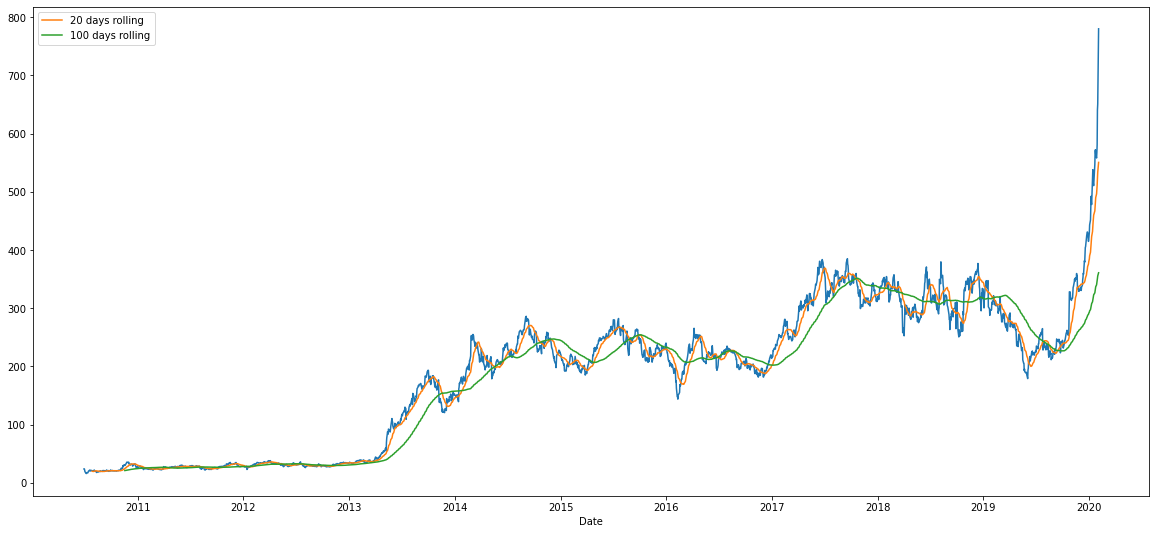

In [8]:


query = 'Select Date,Close from TSLA'
Close_temp=execute_sql_statement(query, conn)
Close_p = pd.DataFrame(Close_temp,columns =['Date','Close'])
Close_p['Date'] = pd.to_datetime(Close_p['Date'])
Close_p.index = Close_p['Date']
Close_p.drop('Date',inplace = True,axis =1)

print(Close_p)

short = Close_p.rolling(window=20).mean()
long = Close_p.rolling(window=100).mean() 

fig, ax = plt.subplots(figsize=(20,9))

ax.plot(Close_p.index, Close_p, label='')
ax.plot(short.index,short, label='20 days rolling')
ax.plot(long.index, long, label='100 days rolling')
ax.set_xlabel('Date')

ax.legend()
plt.show()

  

### Close up on 2019-2020

In [9]:
short = Close_p.Close[Close_p.index>'2018-12-21'].rolling(window=20).mean()
long = Close_p[Close_p.index>'2018-12-21'].rolling(window=100).mean() 
ax.plot(Close_p.Close[Close_p.index>'2018-12-21'], Close_p.Close[Close_p.index>'2018-12-21'], label='')
ax.plot(short.index, short, label='20 days rolling')
ax.plot(long.index, long, label='100 days rolling')
ax.set_xlabel('Date')

ax.legend()
plt.show()



### Volume and Close price accoring to Year

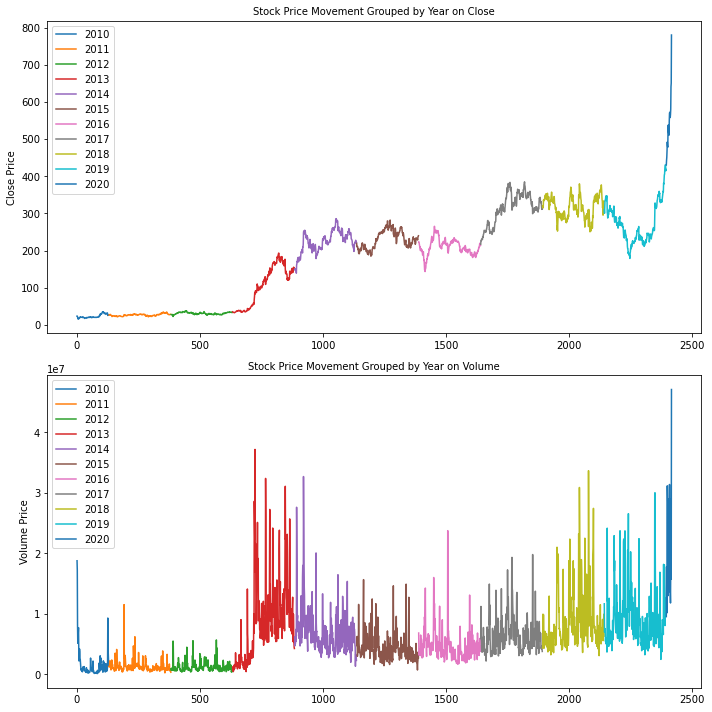

In [10]:
x_plots = ['Close', 'Volume']
query = 'Select Date,Close,Volume from TSLA'
T_analysis=execute_sql_statement(query, conn)
T_analysis = pd.DataFrame(T_analysis,columns =['Date','Close','Volume'])
T_analysis['Date'] = pd.to_datetime(T_analysis['Date'])
T_analysis['Year'] =T_analysis['Date'].dt.year
T_analysis['Month'] =T_analysis['Date'].dt.month
T_analysis['WeekDay'] = T_analysis['Date'].dt.weekday
fig, ax = plt.subplots(len(x_plots), figsize = (10, 10))
for i, col_list in enumerate(x_plots):
    T_analysis.groupby('Year')[col_list].plot(ax = ax[i], legend = True)
    ax[i].set_title("Stock Price Movement Grouped by Year on" + " " + col_list, fontsize = 10)
    ax[i].set_ylabel(col_list + " " + "Price", fontsize = 10)
    fig.tight_layout(pad = 1.1)

### Stocks Traded in every year

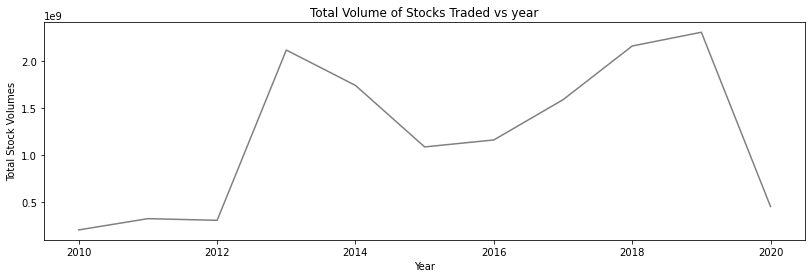

In [11]:
grp_by = T_analysis.groupby('Year')['Volume'].sum()
plt.figure(figsize = (30, 4))
ax1 = plt.subplot(121)
grp_by.plot(y = "Volume", title = "Total Volume of Stocks Traded vs year",  color = "Grey")
ax1.set_ylabel("Total Stock Volumes")
plt.show()


### Stocks Traded based on every Month (1-12)

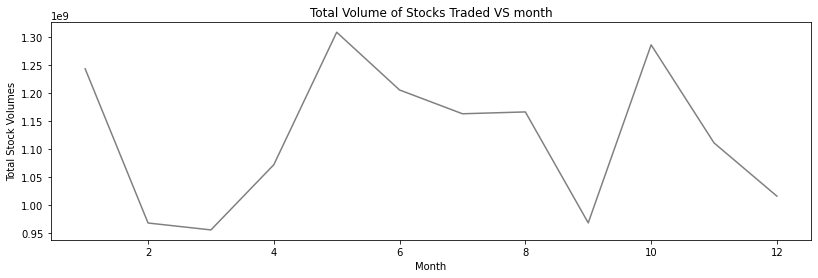

In [12]:
grp_by = T_analysis.groupby('Month')['Volume'].sum()
plt.figure(figsize = (30, 4))
ax1 = plt.subplot(121)
grp_by.plot(y = "Volume", title = "Total Volume of Stocks Traded VS month", color = "grey")
ax1.set_ylabel("Total Stock Volumes")
plt.show()


### Stocks traded based on each day (Mon-Fri)

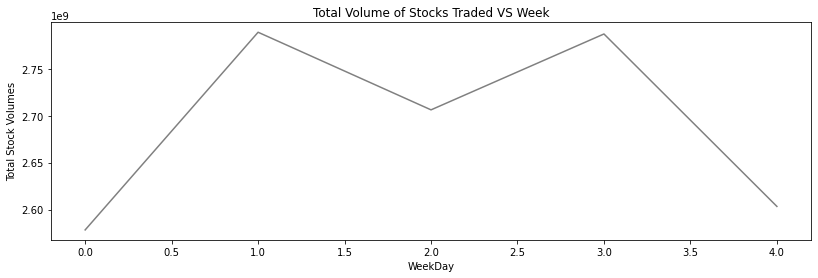

In [13]:
grp_by = T_analysis.groupby('WeekDay')['Volume'].sum()
plt.figure(figsize = (30, 4))
ax1 = plt.subplot(121)
grp_by.plot(y = "Volume",  title = "Total Volume of Stocks Traded VS Week", color = "grey")
ax1.set_ylabel("Total Stock Volumes")
plt.show()


### Pie Chart for volume grouped by year

<Figure size 1152x504 with 0 Axes>

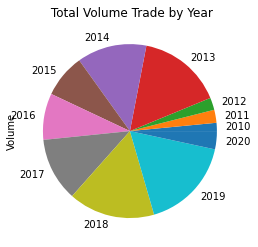

In [14]:
for i, col_list in enumerate(x_plots):
    var = T_analysis.groupby('Year')[col_list].sum()
    
var = pd.DataFrame(var)

plt.figure(figsize = (16, 7))

var.plot(kind = "pie", y = "Volume", title = " Total Volume Trade by Year",legend=False)
plt.show()


### Calculating Relative Strength Index(RSI)

In [15]:
diff=Close_p.Close.diff().dropna()
plus=diff.map(lambda x: x if x>0 else 0).rename('Plus')
minus=diff.map(lambda x: -1*x if x<0 else 0).rename('Minus')
T_analysis.index = T_analysis['Date']
vol = T_analysis.Volume
rsi=pd.concat([vol,diff,plus,minus],axis=1)
rsi['AverageUP'] = rsi.Plus[:14].sum()/14
rsi['AverageDOWN'] = rsi.Minus[:14].sum()/14
for i in range(14,rsi.Close.size):
    rsi['AverageUP'].iloc[i]=(rsi['Plus'].iloc[i] + 13*rsi['AverageUP'].iloc[i-1])/14
    rsi['AverageDOWN'].iloc[i]=(rsi['Minus'].iloc[i] + 13*rsi['AverageDOWN'].iloc[i-1])/14
rsi['RSI']=100 - 100 / (1+rsi['AverageUP']/rsi['AverageDOWN'])
rsi.head()

/Users/saipavan/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


,Volume,Close,Plus,Minus,AverageUP,AverageDOWN,RSI
Date,,,,,,,
2010-06-29,18766300,NaN,NaN,NaN,0.465714,0.607143,43.408791
2010-06-30,17187100,-0.059999,0.0,0.059999,0.465714,0.607143,43.408791
2010-07-01,8218800,-1.870001,0.0,1.870001,0.465714,0.607143,43.408791
2010-07-02,5139800,-2.759998,0.0,2.759998,0.465714,0.607143,43.408791
2010-07-06,6866900,-3.090000,0.0,3.090000,0.465714,0.607143,43.408791


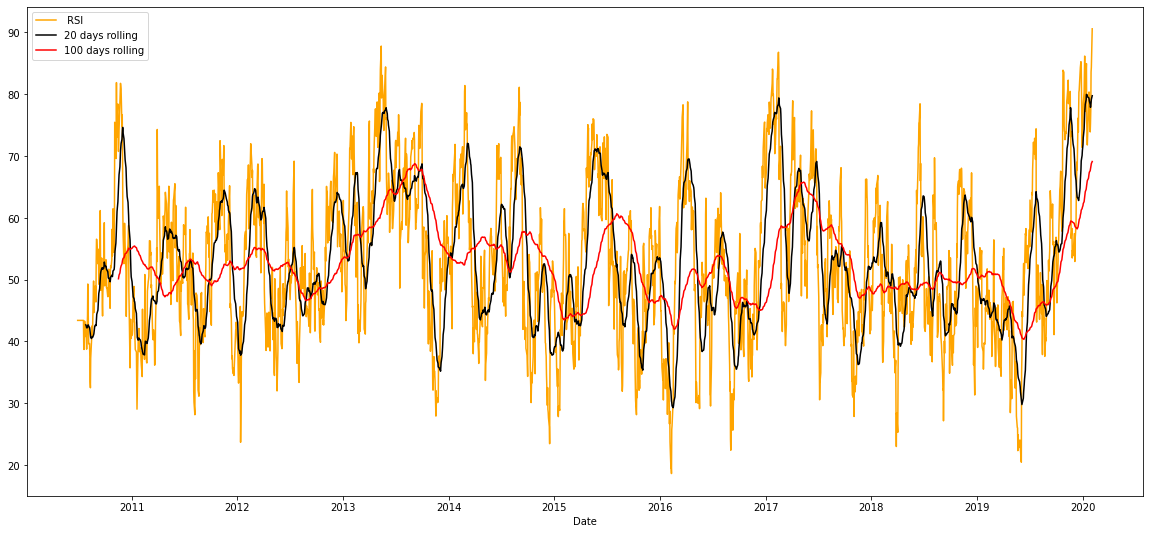

In [16]:
short = rsi['RSI'].rolling(window=20).mean()
long = rsi['RSI'].rolling(window=100).mean()
fig, ax = plt.subplots(figsize=(20,9))

ax.plot(rsi['RSI'].index,rsi['RSI'], label=' RSI', color= 'orange')
ax.plot(short.index, short, label='20 days rolling', color='black')
ax.plot(long.index, long, label='100 days rolling', color='red')
ax.set_xlabel('Date')
ax.legend()
plt.show()


### Checking the trend just before the raise of stocks based on RSI and Volume of stocks (Divergence)

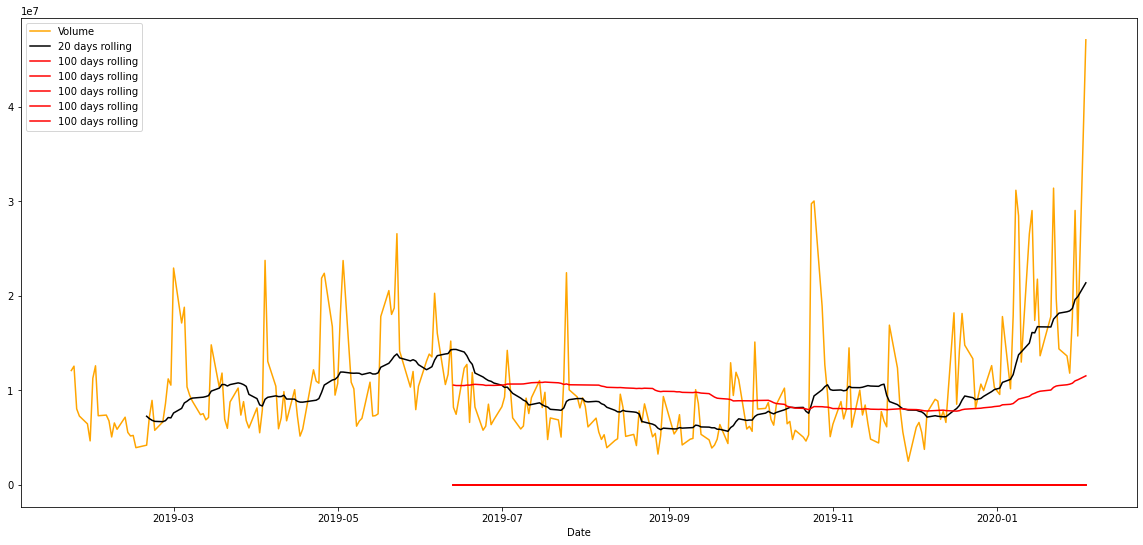

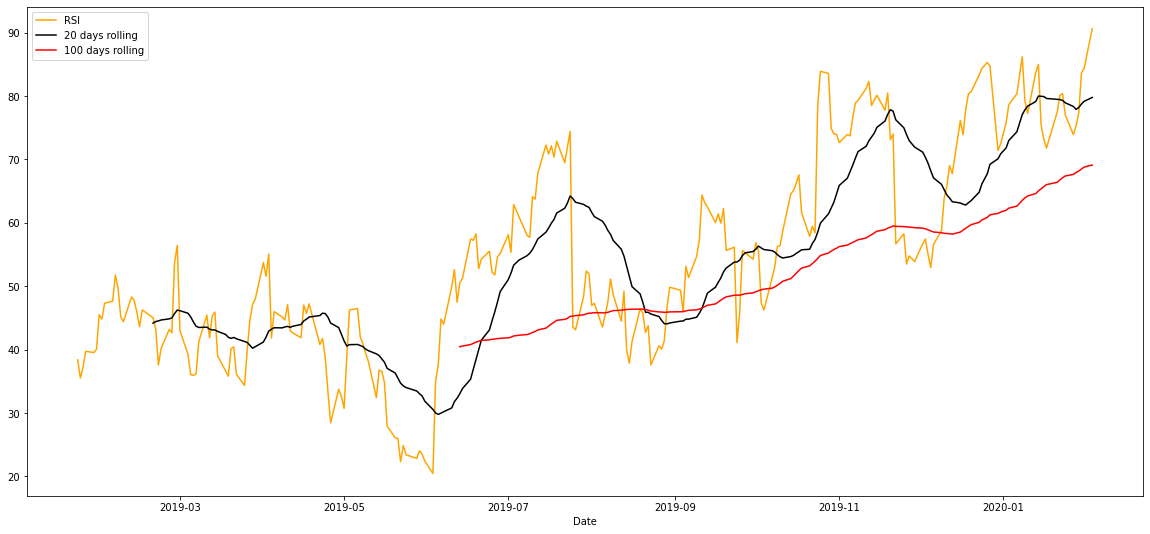

In [17]:
short1 = T_analysis.Volume[rsi.index>'2019-01-21'].rolling(window=20).mean()
long1 = T_analysis[rsi.index>'2019-01-21'].rolling(window=100).mean()
fig, ax = plt.subplots(figsize=(20,9))

ax.plot(T_analysis.Volume[T_analysis.index>'2019-01-21'].index,T_analysis.Volume[T_analysis.index>'2019-01-21'], label='Volume',color='orange')
ax.plot(short1.index, short1, label='20 days rolling',color='black')
ax.plot(long1.index, long1, label='100 days rolling',color='red')
ax.set_xlabel('Date')
ax.legend()
plt.show()



#plot_r_average(data=T_analysis.Volume[T_analysis.index>'2019-01-21'],small_avrg=short1,big_avrg=long1,lbl='Volume')
short = rsi.RSI[rsi.index>'2019-01-21'].rolling(window=20).mean()
long = rsi.RSI[rsi.index>'2019-01-21'].rolling(window=100).mean()

fig, ax = plt.subplots(figsize=(20,9))

ax.plot(rsi.RSI[rsi.index>'2019-01-21'].index,rsi.RSI[rsi.index>'2019-01-21'], label='RSI',color='orange')
ax.plot(short.index, short, label='20 days rolling',color='black')
ax.plot(long.index, long, label='100 days rolling',color='red')
ax.set_xlabel('Date')
ax.legend()
plt.show()


 

In [20]:
close_price = Close_p.Close[(Close_p.index>'2017-12-31')]
train_close = Close_p.Close[(Close_p.index>'2017-12-31') & (Close_p.index<'2019-12-23')].values.reshape(-1, 1)
all_close = Close_p.Close[Close_p.index>'2017-12-31'].values.reshape(-1, 1)
scaler = MinMaxScaler()
scaled_all_close = scaler.fit_transform(all_close)
scaled_train_close = scaler.transform(train_close) 
print(f' Train Size = {scaled_train_close.shape}')
WINDOW_SIZE = 10
X= list()
y=list()
for i in range(scaled_train_close.shape[0]-WINDOW_SIZE):
    seq_x, seq_y = scaled_train_close[i:i+WINDOW_SIZE],scaled_train_close[i+WINDOW_SIZE]
    X.append(seq_x)
    y.append(seq_y)
X=np.array(X)
y=np.array(y)
X = X.reshape((X.shape[0], X.shape[1], 1))
print(f' X Size = {X.shape}')
print(f' y Size = {y.shape}')


 Train Size = (497, 1)
 X Size = (487, 10, 1)
 y Size = (487, 1)


In [73]:
#LSTM model
model = Sequential()
model.add(LSTM(12, activation='relu', input_shape=(WINDOW_SIZE, 1)))
model.add(Dense(25, activation='relu'))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(X, y, batch_size=64, epochs=100, shuffle=False)


Epoch 1/100
9/9 [==============================] - 2s 9ms/step - loss: 0.0586
Epoch 2/100
9/9 [==============================] - 0s 6ms/step - loss: 0.0418
Epoch 3/100
9/9 [==============================] - 0s 7ms/step - loss: 0.0321
Epoch 4/100
9/9 [==============================] - 0s 6ms/step - loss: 0.0247
Epoch 5/100
9/9 [==============================] - 0s 8ms/step - loss: 0.0190
Epoch 6/100
9/9 [==============================] - 0s 8ms/step - loss: 0.0150
Epoch 7/100
9/9 [==============================] - 0s 9ms/step - loss: 0.0126
Epoch 8/100
9/9 [==============================] - 0s 9ms/step - loss: 0.0114
Epoch 9/100
9/9 [==============================] - 0s 8ms/step - loss: 0.0110
Epoch 10/100
9/9 [==============================] - 0s 9ms/step - loss: 0.0106
Epoch 11/100
9/9 [==============================] - 0s 8ms/step - loss: 0.0096
Epoch 12/100
9/9 [==============================] - 0s 8ms/step - loss: 0.0077
Epoch 13/100
9/9 [==============================] - 0s 8ms/st

17/17 [==============================] - 0s 3ms/step - loss: 7.9701e-04
 Mean Squared Error = 0.0007970138103701174


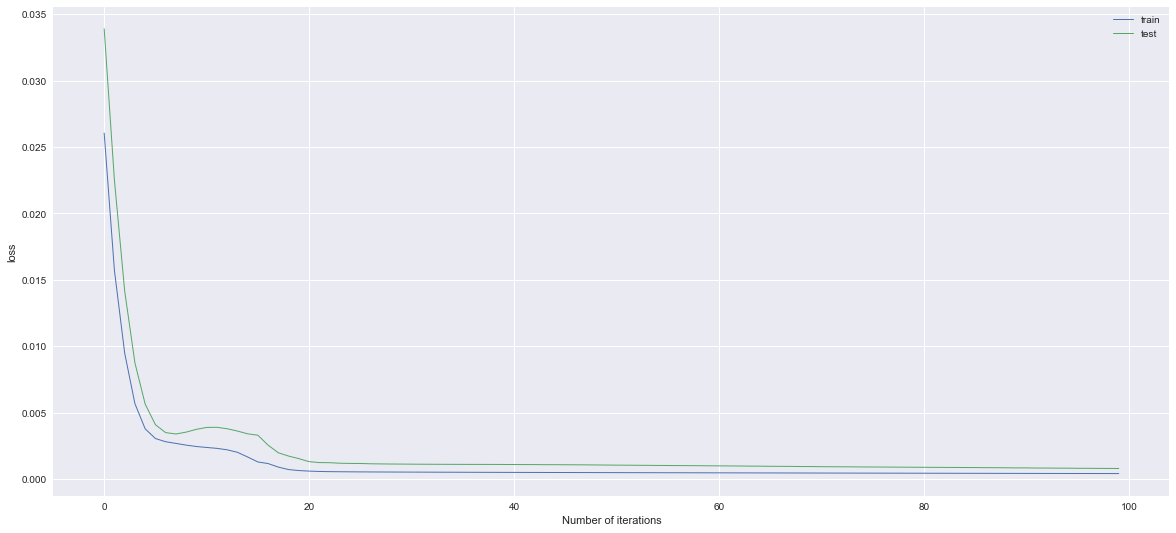

In [74]:
trainScore = model.evaluate(X, y)
print(f' Mean Squared Error = {trainScore}')
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.ylabel('loss')
plt.xlabel('Number of iterations')
plt.legend(['train', 'test'], loc='upper right')
plt.show()

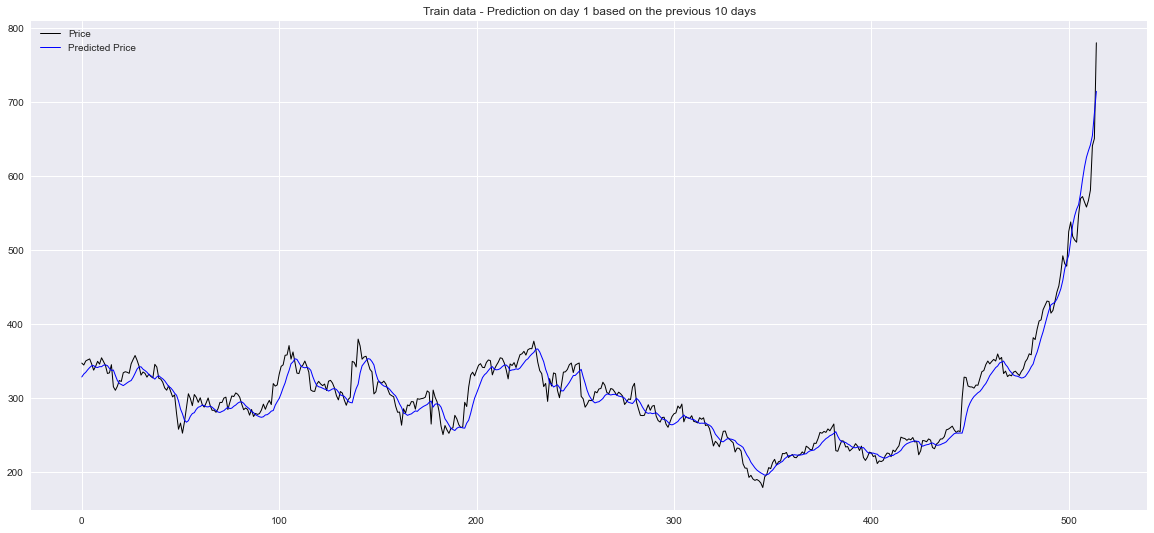

In [75]:
y_train_predicted = model.predict(X)
y_inverse = scaler.inverse_transform(y)
y_train_predicted_inverse = scaler.inverse_transform(y_train_predicted)
plt.plot(y_inverse.ravel(), label="Price", color='black')
plt.plot(y_train_predicted_inverse.ravel(), label="Predicted Price", color='blue')
plt.legend(loc='upper left')
plt.title(f'Train data - Prediction on day 1 based on the previous {WINDOW_SIZE} days')
plt.show()

 X Size = (515, 10, 1)
 y Size = (515, 1)


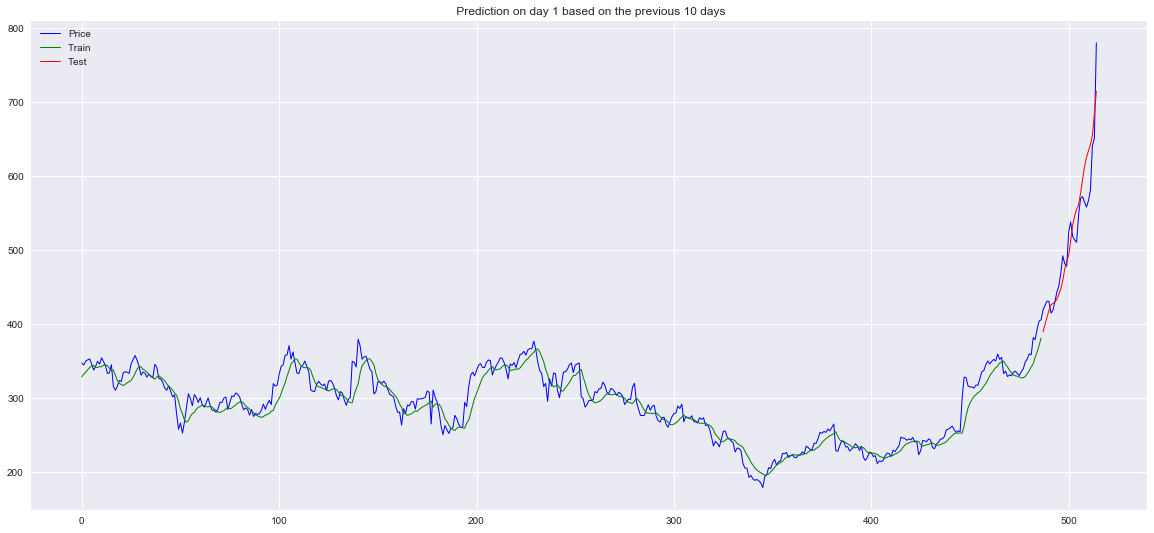

In [77]:
X= list()
y=list()
for i in range(scaled_all_close.shape[0]-WINDOW_SIZE):
    seq_x, seq_y = scaled_all_close[i:i+WINDOW_SIZE],scaled_all_close[i+WINDOW_SIZE]
    X.append(seq_x)
    y.append(seq_y)
X=np.array(X)
y=np.array(y)
X = X.reshape((X.shape[0], X.shape[1], 1))
print(f' X Size = {X.shape}')
print(f' y Size = {y.shape}')
y_predicted = model.predict(X)
y_inverse = scaler.inverse_transform(y)
y_predicted_inverse = scaler.inverse_transform(y_predicted)
plt.plot(y_inverse.ravel(), label="Price", color='blue')
plt.plot(pd.Series(y_predicted_inverse[:487].ravel(),index=range(0,487)), label="Train ", color='green')
plt.plot(pd.Series(y_predicted_inverse[487:].ravel(),index=range(487,515)), label="Test ", color='red')
plt.legend(loc='upper left')
plt.title(f" Prediction on day 1 based on the previous {WINDOW_SIZE} days")
plt.show()